# Sepsis-3 in MIMIC-III

This is the primary notebook for analyzing sepsis-3 in the MIMIC-III database. Before running this notebook, you'll need the `sepsis3-df.csv` file in the local directory: either by downloading it directly from PhysioNet or running the SQL scripts enclosed on the MIMIC-III database. See `sepsis-3-get-data.ipynb` for more detail.

In [1]:
from __future__ import print_function

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import tableone
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru
from sepsis_utils import venn

# venn diagram with matplotlib-venn
from matplotlib_venn import venn3



# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples


%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
df = pd.read_csv('sepsis3-df-mv.csv')

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['blood culture', 'Blood culture'],
          ['suspicion_mv', 'BC + ABX (IV administered)'],
          ['suspicion_poe', 'BC + ABX (Prescribed)'],
          ['suspicion_d1poe', 'BC + ABX (Prescribed day1)']])

# add some other useful variables
df['blood culture'] = (~df['suspected_infection_time_days'].isnull())
df['suspicion_mv'] = (~df['suspected_infection_time_mv_days'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())
df['suspicion_d1poe'] = (~df['suspected_infection_time_d1poe_days'].isnull())
df['suspicion_piv'] = (~df['suspected_infection_time_piv_days'].isnull())

df['sepsis-3'] = (df['suspicion_poe']==1) & (df['sofa']>=2)
df['sofa>=2'] = (df['sofa']>=2)
df['sepsis-3-mv'] = (df['suspicion_mv']==1) & (df['sofa']>=2)


for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe']:
    if df[c].dtype == 'object':
        df[c] = pd.to_datetime(df[c])
        
df.head()

,icustay_id,hadm_id,intime,outtime,dbsource,suspected_infection_time,suspected_infection_time_days,specimen,positiveculture,suspected_infection_time_mv,...,qsofa_resprate_score_norx,composite_outcome,blood culture,suspicion_mv,suspicion_poe,suspicion_d1poe,suspicion_piv,sepsis-3,sofa>=2,sepsis-3-mv
0,200021,109307,2114-12-26 19:45:12,2114-12-27 22:46:28,metavision,2114-12-27 15:00:00,-0.801944,MRSA SCREEN,0.0,NaT,...,1.0,0,True,False,False,False,False,False,True,False
1,200028,181955,2133-10-29 17:13:50,2133-11-01 14:55:14,metavision,2133-10-29 19:27:00,-0.092477,BLOOD CULTURE,0.0,NaT,...,1.0,0,True,False,False,False,False,False,True,False
2,200033,198650,2198-08-07 17:56:17,2198-08-21 14:59:18,metavision,2198-08-08 01:00:00,-0.294248,MRSA SCREEN,0.0,NaT,...,0.0,1,True,False,False,False,False,False,False,False
3,200061,121149,2134-01-23 16:38:46,2134-01-25 16:59:14,metavision,2134-01-24 00:30:00,-0.327245,BLOOD CULTURE,0.0,2134-01-24 00:30:00,...,1.0,0,True,True,True,True,True,True,True,True
4,200072,129935,2106-03-03 19:39:49,2106-03-06 16:55:08,metavision,2106-03-04 02:39:00,-0.291100,MRSA SCREEN,0.0,NaT,...,1.0,0,True,False,False,False,False,False,False,False


# Demographics

In [3]:
# Call the print_demographics subfunction, which prints out a reasonably formatted table
reload(su)
su.print_demographics(df)

print('\nAlive vs. dead')
su.print_demographics(df, idx=(df.hospital_expire_flag.values==1))

print('')

print('{:5g} have SIRS >= 2 ({:2.2f}%) on admission.'.format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean()))

print('{:5g} have qSOFA >= 2 ({:2.2f}%) on admission.'.format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean()))

print('{:5g} have SOFA >= 2 ({:2.2f}%).'.format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean()))

print('{:5g} have LODS >= 2 ({:2.2f}%).'.format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean()))

N                   	12394
age                 	64.7 [51.3, 78.5]
gender              	6820 (55.0%)
bmi                 	28.7 +- 8.3
Race                	
White               	8933 (72.1%)
Black               	1171 (9.4%)
Hispanic            	 466 (9.4%)
elixhauser_hospital 	1.0 [-1.0, 6.0]
qsofa               	2.0 [1.0, 2.0]
sirs                	3.0 [2.0, 3.0]
sofa                	3.0 [2.0, 5.0]
mlods               
lactate_max         	2.7 +- 2.4
lactate measured    	5577 (45.0%)
lactate > 2         	2786 (22.5%)
vent                	4392 (35.4%)
icu_los             	1.9 [1.1, 3.7]
hosp_los            	5.9 [3.2, 10.1]
thirtyday_expire_flag	1693 (13.7%)
hospital_expire_flag	1342 (10.8%)

Alive vs. dead
N                   	11052     	1342     	     
age                 	63.6 [50.3, 77.5]	74.7 [61.9, 83.5]	< 0.001
gender              	6100 (55.2%)	 720 (53.7%)	0.297
bmi                 	28.7 +- 8.2	28.1 +- 10.0	0.150
ethnicity           	          	          	< 0.001
  black           

# Severity of illness stats

In [29]:
df['sepsis-3'].max()

True

In [32]:
print('{:5g} ({:3.1f}%) first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
for c in ['sirs','qsofa','sofa','sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit']:
    if df[c].max() == 1:
        print('{:5g} ({:3.1f}%)  with {}'.format(
                (df[c]==1).sum(),
                (df[c]==1).sum()*100.0/df.shape[0], c))
    else:
        print('{:5g} ({:3.1f}%)  with {} >= 2'.format(
                (df[c]>=2).sum(),
                (df[c]>=2).sum()*100.0/df.shape[0], c))

12394 (100.0%) first ICU stay for adults.
10702 (86.3%)  with sirs >= 2
 8395 (67.7%)  with qsofa >= 2
 9323 (75.2%)  with sofa >= 2
 4872 (39.3%)  with sepsis-3
 3677 (29.7%)  with sepsis_angus
 1793 (14.5%)  with sepsis_martin
 1072 (8.6%)  with sepsis_explicit


In [5]:
print('{:5g} ({:3.1f}%) first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))

N = (df['qsofa_norx']<2).sum()
print('{:5g} ({:3.1f}%)  with qSOFA < 2'.format(N, N*100.0/df.shape[0]))

N = ((df['qsofa_resprate_score_norx']==0)&(df['qsofa_resprate_score']==1)).sum()
print('{:5g} ({:3.1f}%)  with mech vent increase'.format(N, N*100.0/df.shape[0]))

N = ((df['qsofa_sysbp_score_norx']==0)&(df['qsofa_sysbp_score']==1)).sum()
print('{:5g} ({:3.1f}%)  with vasopressor increase'.format(N, N*100.0/df.shape[0]))

N = ( \
     ((df['qsofa_resprate_score_norx']==0)&(df['qsofa_resprate_score']==1)) & \
     ((df['qsofa_sysbp_score_norx']==0)&(df['qsofa_sysbp_score']==1)) \
    ).sum()
print('{:5g} ({:3.1f}%)  with both increased'.format(N, N*100.0/df.shape[0]))

N = ((df['qsofa_norx']<2)&(df['qsofa']>=2)).sum()
print('{:5g} ({:3.1f}%)  with qSOFA increased to >= 2'.format(N, N*100.0/df.shape[0]))

N = (df['qsofa']>=2).sum()
print('{:5g} ({:3.1f}%)  with qSOFA>=2 (incl treatment flags)'.format(N, N*100.0/df.shape[0]))

12394 (100.0%) first ICU stay for adults.
 4527 (36.5%)  with qSOFA < 2
  693 (5.6%)  with mech vent increase
  148 (1.2%)  with vasopressor increase
   16 (0.1%)  with both increased
  528 (4.3%)  with qSOFA increased to >= 2
 8395 (67.7%)  with qSOFA>=2 (incl treatment flags)


## AUROC of severity of illness scores

In [6]:
# ensure bootstrap always results in the same confidence intervals
np.random.seed(978236412)

# define outcome
target_header = "hospital_expire_flag"

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)

print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

AUROC table for unadjusted scores:
     	sirs                	qsofa               	sofa                	
sirs 	0.637 [0.622, 0.651]	0.451 [0.433, 0.467]	0.264 [0.252, 0.274]	
qsofa	

sepsis_utils/roc_utils.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'array' not in (pred[0]):


Input sizes may not match!
0.874               	0.635 [0.622, 0.649]	0.316 [0.308, 0.324]	
sofa 	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	0.750 [0.735, 0.765]	




# Sepsis

Create the sepsis-3 criteria: SOFA >= 2 and suspicion of infection.

In [7]:
print('{:5g} ({:3.2f}%)  first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
print('{:5g} ({:3.2f}%)  suspected of infection'.format(
        np.sum(~df['suspected_infection_time_days'].isnull()),
        np.sum(~df['suspected_infection_time_days'].isnull())*100.0/df.shape[0]))
print('{:5g} ({:3.2f}%)  with a positive blood culture'.format(
    df['positiveculture'].sum(), df['positiveculture'].sum()*100.0/df.shape[0]))

print()
for i, c in enumerate(labels):
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))
    
for c in ['sepsis_angus','sepsis_martin','sepsis_explicit']:
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

12394 (100.00%)  first ICU stay for adults.
11357 (91.63%)  suspected of infection
 1080 (8.71%)  with a positive blood culture

11357 (91.63%) - blood culture
 5641 (45.51%) - suspicion_mv
 5954 (48.04%) - suspicion_poe
 6061 (48.90%) - suspicion_d1poe
 3677 (29.67%) - sepsis_angus
 1793 (14.47%) - sepsis_martin
 1072 (8.65%) - sepsis_explicit


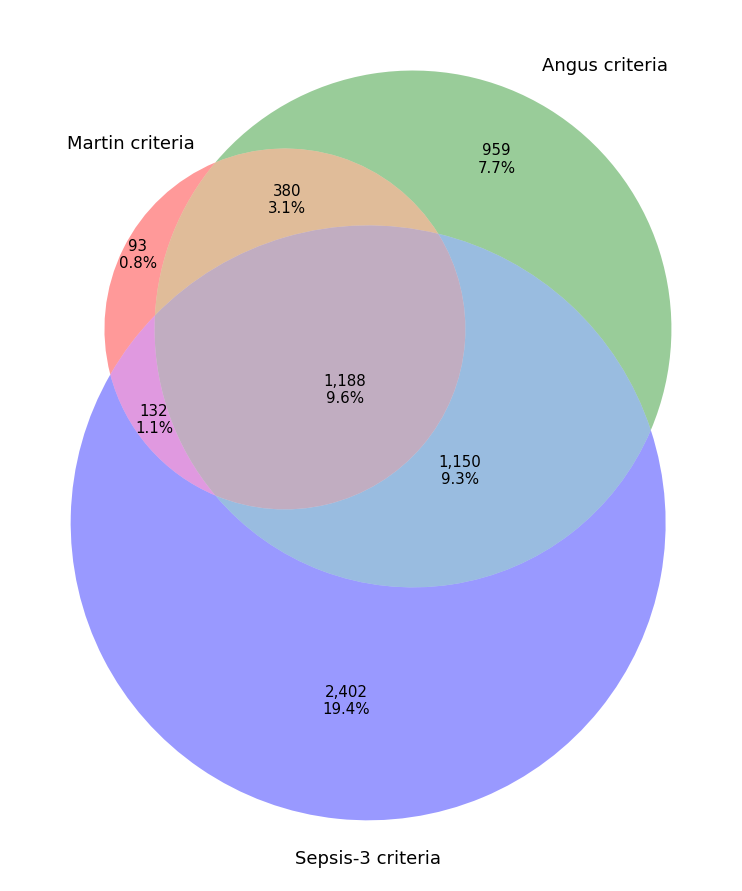

1188 patients (9.6%) satisfied all criteria.
6090 patients (49.1%) satisfied no criteria.
12.7% (1568) - sepsis_angus & sepsis_martin
10.7% (1320) - sepsis-3 & sepsis_martin
18.9% (2338) - sepsis-3 & sepsis_angus


In [8]:
# venn diagram with matplotlib-venn
from matplotlib_venn import venn3


venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# pair-wise counts
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

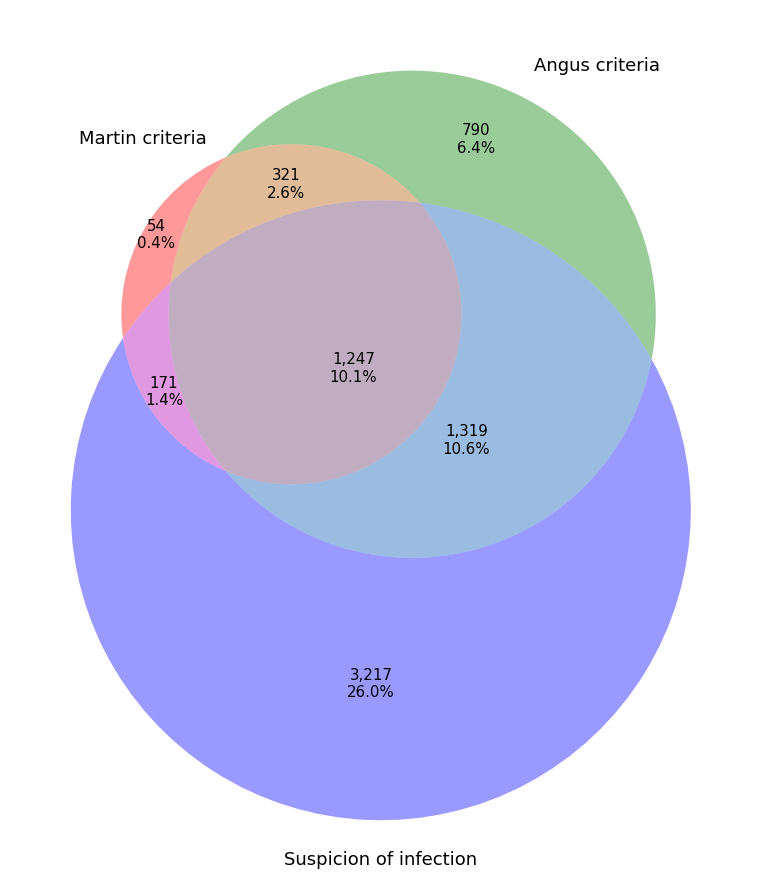

1247 patients (10.1%) satisfied all criteria.
5275 patients (42.6%) satisfied no criteria.
12.7% (1568) - sepsis_angus & sepsis_martin
11.4% (1418) - suspicion_poe & sepsis_martin
20.7% (2566) - suspicion_poe & sepsis_angus


In [9]:
venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

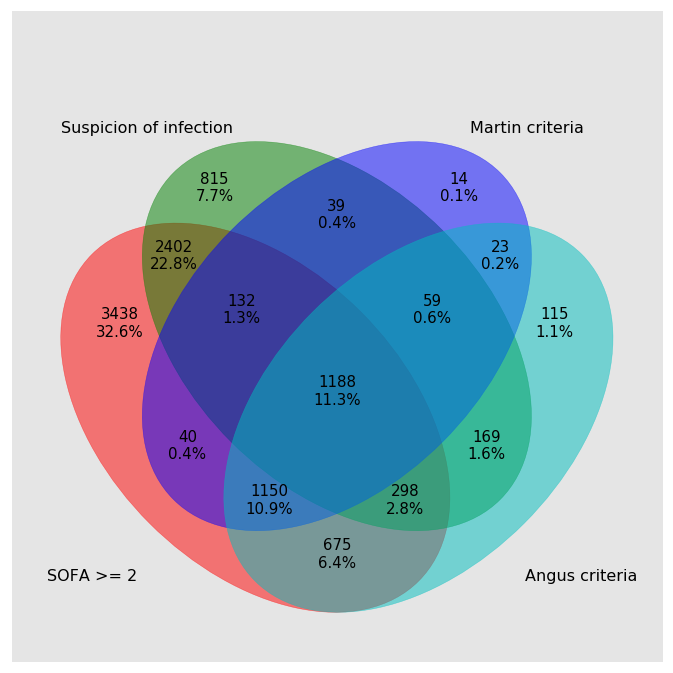

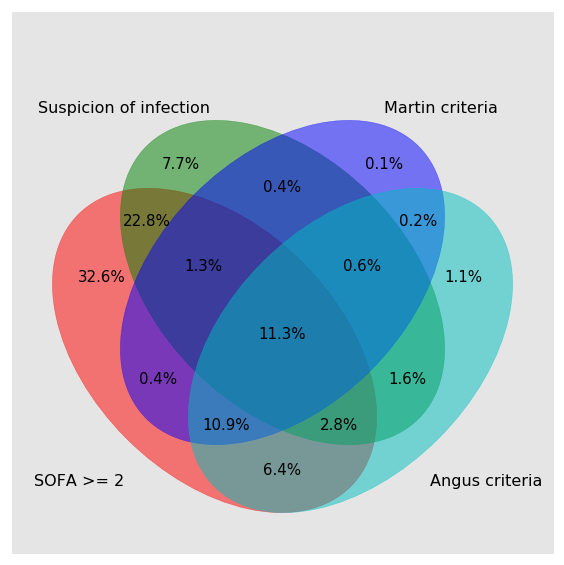

1188 patients (9.6%) satisfied all criteria.
1837 patients (14.8%) satisfied no criteria.
26.7% (3311) - sepsis_angus & sofa>=2
39.3% (4872) - suspicion_poe & sofa>=2
20.7% (2566) - suspicion_poe & sepsis_angus
13.4% (1658) - sepsis_martin & sofa>=2
12.7% (1568) - sepsis_martin & sepsis_angus
11.4% (1418) - sepsis_martin & suspicion_poe


In [39]:
reload(venn)

venn_labels = OrderedDict([
        ['sofa>=2', 'SOFA >= 2'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection'],
        ['sepsis_martin', 'Martin criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[12,12])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))



# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

# Venn diagram with mortality

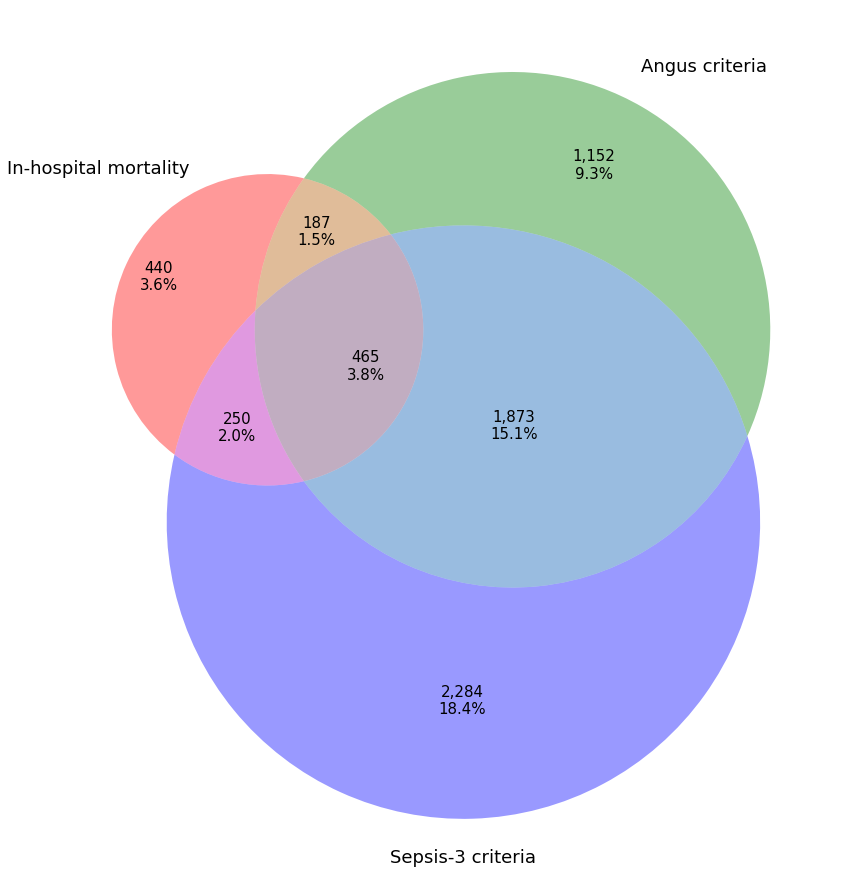

465 patients (3.8%) satisfied all criteria.
5743 patients (46.3%) satisfied no criteria.
5.3% (652) - sepsis_angus & hospital_expire_flag
5.8% (715) - sepsis-3 & hospital_expire_flag
18.9% (2338) - sepsis-3 & sepsis_angus


In [35]:
venn_labels = OrderedDict([
        ['hospital_expire_flag', 'In-hospital mortality'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

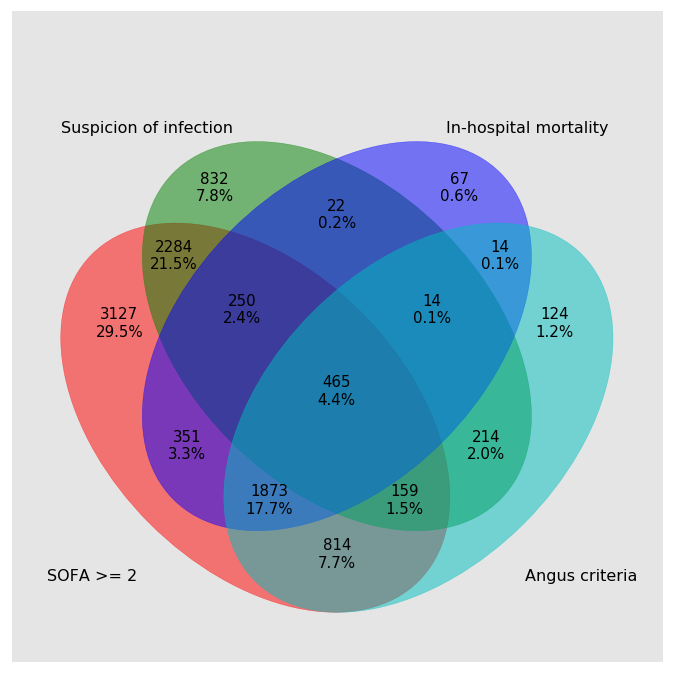

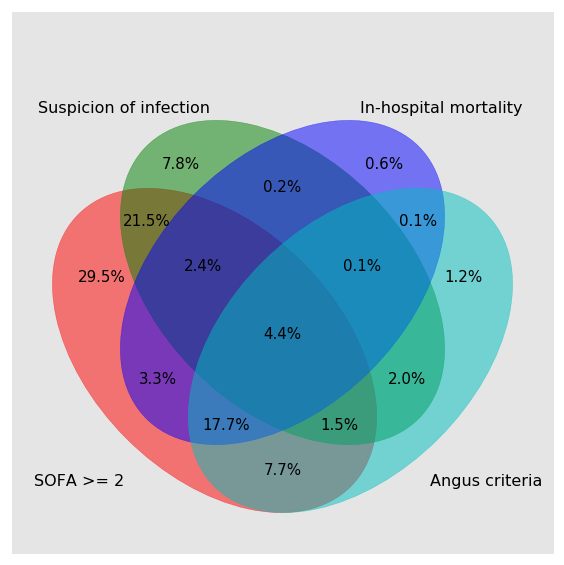

465 patients (3.8%) satisfied all criteria.
1784 patients (14.4%) satisfied no criteria.
26.7% (3311) - sepsis_angus & sofa>=2
39.3% (4872) - suspicion_poe & sofa>=2
20.7% (2566) - suspicion_poe & sepsis_angus
9.9% (1225) - hospital_expire_flag & sofa>=2
5.3% (652) - hospital_expire_flag & sepsis_angus
6.1% (751) - hospital_expire_flag & suspicion_poe


In [38]:
reload(venn)

venn_labels = OrderedDict([
        ['sofa>=2', 'SOFA >= 2'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection'],
        ['hospital_expire_flag', 'In-hospital mortality']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[12,12])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))


for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

## add in year .. if available

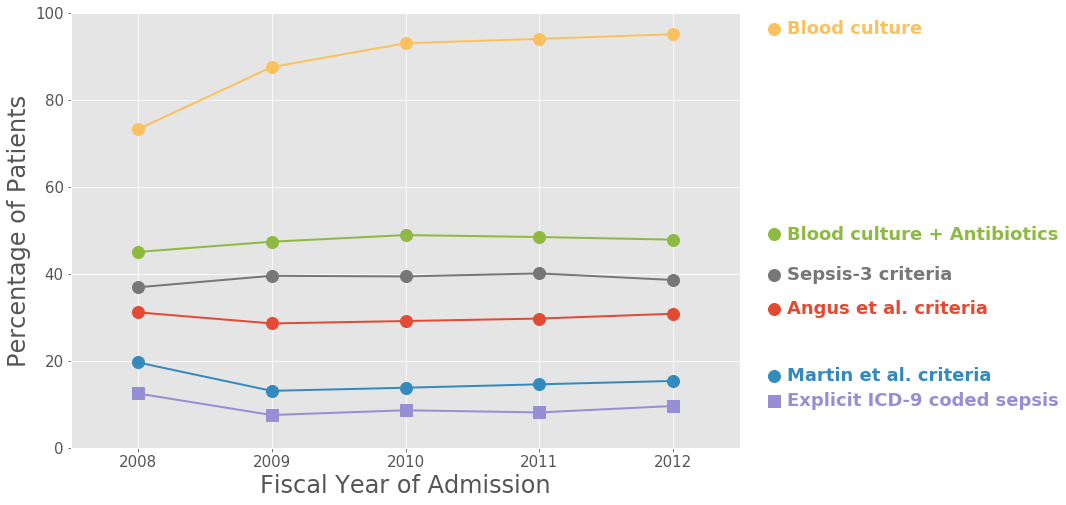

Score          	2008	2009	2010	2011	2012
sepsis_angus   	31.2	28.6	29.1	29.7	30.8
sepsis_martin  	19.6	13.1	13.8	14.6	15.4
sepsis_explicit	12.5	7.5	8.6	8.1	9.6
sepsis-3       	36.9	39.6	39.4	40.1	38.6
blood culture  	73.2	87.5	93.0	94.0	95.1
suspicion_poe  	45.0	47.4	48.9	48.5	47.9


In [11]:
if not os.path.isfile('mimiciii_admission_year.csv'):
    print('Cannot create plot as years are not available.')
else:
    yr = pd.read_csv('mimiciii_fiscal_year.csv')
    # set columns to lower case
    yr.columns = [x.lower() if x != 'FISCALYEAR' else 'year' for x in yr.columns]
    
    yr = yr.merge(df, how='inner', left_on='hadm_id', right_on='hadm_id')
    
    yr_keep = np.linspace(2008,2012,5)
    # create a dataframe that indicates if a patient has:
    # heart rate, blood pressure, temperature, respiration rate
    # in the first day.

    sepsis = ['sepsis_angus','sepsis_martin','sepsis_explicit', 'sepsis-3',
              #'septic_shock_explicit', 'severe_sepsis_explicit', 'suspicion_mv',
              'blood culture', 'suspicion_poe']


    grouped = yr.loc[np.in1d(yr['year'],yr_keep),:].groupby('year')

    plt.figure(figsize=[12,8])

    # get the x-axis from the original data - right now it's plotting against 0:NUMBER_OF_YEARS
    year = np.unique(yr['year'].values)
    Y = year.size

    # set x-axis labels to years
    #ax.set_xticks(range(Y))
    #ax.set_xticklabels(year,fontsize=14)

    pretty_labels = {'sepsis_angus': 'Angus et al. criteria',
                    'sepsis_martin': 'Martin et al. criteria',
                    'sepsis_explicit': 'Explicit ICD-9 coded sepsis',
                    'septic_shock_explicit': 'ICD-9 code 785.52 (septic shock)',
                    'severe_sepsis_explicit': 'ICD-9 code 995.92 (severe sepsis)',
                    'sofa>=2': 'SOFA >= 2',
                    'sepsis-3': 'Sepsis-3 criteria',
                    'blood culture': 'Blood culture',
                    'suspicion_mv': 'Blood culture + Antibiotics (IV)',
                    'suspicion_poe': 'Blood culture + Antibiotics',
                    'suspicion_piv': 'Blood culture + Antibiotics (POE IV)'}
    # ===================== #
    # === PLOT THE DATA === #
    # ===================== #  
    for i, s in enumerate(sepsis):
        marker='o'
        if s == 'severe_sepsis_explicit':
            marker='^'
        elif s == 'sepsis_explicit':
            marker='s'
        p = plt.plot(grouped.apply(lambda subf: subf[s].mean()*100.0), label=pretty_labels[s],
                linewidth=2,linestyle='-',marker=marker,markersize=12)


        # Add a text label to the right end of every line
        y_pos = yr.loc[ yr['year'] == yr_keep[-1],s ].mean()*100.0
        x_pos = 2012.85
        
        if s == 'sepsis_explicit':
            y_pos = y_pos
            
        elif s == 'severe_sepsis_explicit':
            y_pos = y_pos-3
            
        elif s == 'septic_shock_explicit':
            y_pos = y_pos-6
            
        #elif s == 'suspicion_mv':
        #    y_pos = y_pos-2
            
        #elif s == 'suspicion_poe':
        #    y_pos = y_pos+2
            
        # plot the symbol
        plt.plot(x_pos-0.1, y_pos+1.2, linestyle='',
                 color=p[0].get_color(), clip_on=False,
                 marker=marker, markersize=12)
        plt.text(x_pos, y_pos, pretty_labels[s],
                 fontsize=18, fontweight='bold', color=p[0].get_color())    


    # pretty the plot
    plt.ylabel('Percentage of Patients', fontsize=24)
    #plt.legend(loc=[0.6,0.45])
    plt.xticks(yr_keep)
    plt.ylim([0,100])
    plt.xlim([yr_keep[0]-.5,yr_keep[-1]+.5])
    plt.xlabel('Fiscal Year of Admission', fontsize=24)
    plt.savefig('SepsisOverTime.png')
    
    plt.show()
    # print table
    print('{:15s}'.format('Score'),end='')
    for i, y in enumerate(yr_keep):
        print('\t{:g}'.format(y),end='')
    print('')
    
    for i, s in enumerate(sepsis):
        print('{:15s}'.format(s),end='')
        for y in yr_keep:
                print('\t{:2.1f}'.format( np.sum(yr.loc[yr['year']==y,s])*100.0/np.sum(yr['year']==y)),end='')
        print('')

# Mortality rates for each group

In [12]:
target_header = "hospital_expire_flag"
idx = df[target_header]==1

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']

print('{:15s} {:15s} {:15s}'.format('0','dead','alive','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead            alive          
sepsis_angus     690 5.6%	 8027 64.8%  7.9%
sepsis_martin    922 7.4%	 9679 78.1%  8.7%
sepsis_explicit 1005 8.1%	10317 83.2%  8.9%
suspicion_poe    591 4.8%	 5849 47.2%  9.2%
sepsis-3         627 5.1%	 6895 55.6%  8.3%
sofa>=2          117 0.9%	 2954 23.8%  3.8%

1
sepsis_angus     652 5.3%	 3025 24.4%  17.7%
sepsis_martin    420 3.4%	 1373 11.1%  23.4%
sepsis_explicit  337 2.7%	  735 5.9%  31.4%
suspicion_poe    751 6.1%	 5203 42.0%  12.6%
sepsis-3         715 5.8%	 4157 33.5%  14.7%
sofa>=2         1225 9.9%	 8098 65.3%  13.1%


# Composite outcome for each group

In [13]:
target_header = "composite_outcome"
idx = (df['hospital_expire_flag']==1) | (df['icu_los']>=3)

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']


print('{:15s} {:12s} {:15s}'.format('0','dead/hi-LOS','alive/lo-LOS','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead/hi-LOS  alive/lo-LOS   
sepsis_angus    2287 18.5%    6430 51.9%  26.2%
sepsis_martin   3464 27.9%    7137 57.6%  32.7%
sepsis_explicit 3791 30.6%    7531 60.8%  33.5%
suspicion_poe   1875 15.1%    4565 36.8%  29.1%
sepsis-3        2163 17.5%    5359 43.2%  28.8%
sofa>=2          626 5.1%    2445 19.7%  20.4%

1
sepsis_angus    2267 18.3%    1410 11.4%  61.7%
sepsis_martin   1090 8.8%     703 5.7%  60.8%
sepsis_explicit  763 6.2%     309 2.5%  71.2%
suspicion_poe   2679 21.6%    3275 26.4%  45.0%
sepsis-3        2391 19.3%    2481 20.0%  49.1%
sofa>=2         3928 31.7%    5395 43.5%  42.1%


# Mortality: operating point statistics

In [14]:
target_header = "hospital_expire_flag"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2954		 1622		 3810
FP   	 8098		 9430		 7242
FN   	  117		   70		  189
TP   	 1225		 1272		 1153
Sens 	91 [90, 93]	95 [93, 96]	86 [84, 88]
Spec 	27 [26, 28]	15 [14, 15]	34 [34, 35]
PPV  	13 [12, 14]	12 [11, 13]	14 [13, 14]
NPV  	96 [95, 97]	96 [95, 97]	95 [95, 96]
F1   	 22.97   	 21.12   	 23.68   
NTP  	 9.88   	 10.26   	 9.30   
NFP  	 65.34   	 76.09   	 58.43   


# Composite outcome: operating point statistics

In [15]:
target_header = "composite_outcome"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2445		 1355		 3128
FP   	 5395		 6485		 4712
FN   	  626		  337		  871
TP   	 3928		 4217		 3683
Sens 	86 [85, 87]	93 [92, 93]	81 [80, 82]
Spec 	31 [30, 32]	17 [16, 18]	40 [39, 41]
PPV  	42 [41, 43]	39 [38, 40]	44 [43, 45]
NPV  	80 [78, 81]	80 [78, 82]	78 [77, 79]
F1   	 56.61   	 55.28   	 56.88   
NTP  	 31.69   	 34.02   	 29.72   
NFP  	 43.53   	 52.32   	 38.02   


## Cronbach alpha and Kuder-Richardson Formula 20 agreement

In [16]:
np.random.seed(21381)
# cronbach alpha for construct validity
reload(su)
print(' === Cronbach Alpha ===')
su.cronbach_alpha_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('')
print(' === KR20 ===')
su.kr20_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('Cronbach alpha is a generalization of KR20 to ordinal items.')

 === Cronbach Alpha ===
          	sepsis_angus        	sepsis_martin       	sepsis_explicit     	sepsis-3            	
sepsis_angus	                    	0.669 [0.658, 0.681]	0.594 [0.582, 0.608]	0.487 [0.470, 0.502]	
sepsis_martin	                    	                    	0.838 [0.829, 0.849]	0.430 [0.412, 0.447]	
sepsis_explicit	                    	                    	                    	0.360 [0.341, 0.373]	
sepsis-3  	                    	                    	                    	                    	

 === KR20 ===
          	sepsis_angus        	sepsis_martin       	sepsis_explicit     	sepsis-3            	
sepsis_angus	                    	0.669 [0.656, 0.681]	0.594 [0.580, 0.608]	0.487 [0.472, 0.503]	
sepsis_martin	                    	                    	0.838 [0.830, 0.850]	0.430 [0.414, 0.447]	
sepsis_explicit	                    	                    	                    	0.360 [0.340, 0.373]	
sepsis-3  	                    	                    	                    	   

# Mortality: build models with different covariates

In [17]:
# define outcome
target_header = "hospital_expire_flag"

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx','sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

AUROC table for unadjusted scores:
     	sirs                	qsofa               	qsofa_norx          	sofa                	
sirs 	0.637 [0.622, 0.651]	0.451 [0.434, 0.467]	0.475 [0.459, 0.490]	0.264 [0.252, 0.275]	
qsofa	Input sizes may not match!
0.874               	0.635 [0.622, 0.649]	0.969 [0.967, 0.971]	0.316 [0.308, 0.323]	
qsofa_norx	Input sizes may not match!
0.014               	Input sizes may not match!
< 0.001               	0.615 [0.601, 0.629]	0.300 [0.292, 0.309]	
sofa 	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	0.750 [0.735, 0.765]	


AUROC table for adjusted scores (using logistic regression):
     	sirs                	qsofa               	qsofa_norx          	sofa                	
sirs 	0.747 [0.734, 0.760]	0.890 [0.885, 0.894]	0.907 [0.904, 0.911]	0.731 [0.720, 0.741]	
qsofa	Input sizes may not match!
0.090               	0.739 [0.726, 0.753]	0.991 [0.990, 0

In [18]:
from statsmodels.formula.api import logit
target_header = "hospital_expire_flag"
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))



# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

sofa - univariable
AUROC=0.750
hospital_expire_flag ~ lactate_missing + lactate_max_imputed + sofa
AUROC=0.759 [0.744 - 0.774]
                            Results: Logit
Model:              Logit                Pseudo R-squared: 0.154      
Dependent Variable: hospital_expire_flag AIC:              7200.7537  
Date:               2017-06-07 16:39     BIC:              7230.4536  
No. Observations:   12394                Log-Likelihood:   -3596.4    
Df Model:           3                    LL-Null:          -4249.9    
Df Residuals:       12390                LLR p-value:      4.3277e-283
Converged:          1.0000               Scale:            1.0000     
No. Iterations:     7.0000                                            
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Intercept             -3.6486   0.0860 -42.4079 0

# Composite outcome - prediction performance

In [19]:
# define outcome
target_header = 'composite_outcome'

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx', 'sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

AUROC table for unadjusted scores:
     	sirs                	qsofa               	qsofa_norx          	sofa                	
sirs 	0.636 [0.626, 0.646]	0.451 [0.434, 0.467]	0.475 [0.459, 0.490]	0.264 [0.252, 0.275]	
qsofa	Input sizes may not match!
0.203               	0.628 [0.620, 0.637]	0.969 [0.967, 0.971]	0.316 [0.308, 0.324]	
qsofa_norx	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	0.605 [0.596, 0.614]	0.300 [0.291, 0.308]	
sofa 	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	Input sizes may not match!
< 0.001               	0.708 [0.698, 0.718]	


AUROC table for adjusted scores (using logistic regression):
     	sirs                	qsofa               	qsofa_norx          	sofa                	
sirs 	0.683 [0.673, 0.693]	0.793 [0.787, 0.799]	0.825 [0.820, 0.830]	0.679 [0.669, 0.687]	
qsofa	Input sizes may not match!
0.562               	0.681 [0.671, 0.690]	0.980 [0.979,

In [20]:
from statsmodels.formula.api import logit
target_header = 'composite_outcome'
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))




# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

sofa - univariable
AUROC=0.708
composite_outcome ~ lactate_missing + lactate_max_imputed + sofa
AUROC=0.732 [0.723 - 0.742]
                           Results: Logit
Model:                Logit             Pseudo R-squared: 0.141     
Dependent Variable:   composite_outcome AIC:              14011.1587
Date:                 2017-06-07 16:40  BIC:              14040.8586
No. Observations:     12394             Log-Likelihood:   -7001.6   
Df Model:             3                 LL-Null:          -8150.0   
Df Residuals:         12390             LLR p-value:      0.0000    
Converged:            1.0000            Scale:            1.0000    
No. Iterations:       6.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -1.4703   0.0607 -24.2319 0.0000 -1.5893 -1.3514
lactat

In [21]:
print('Odds ratios for final model w/ lactate')
for p in model.params.index:
    print('{:20s} {:1.2f}'.format(p, np.exp(model.params[p])))

Odds ratios for final model w/ lactate
Intercept            0.16
age                  1.01
elixhauser_hospital  1.04
lactate_missing      0.70
lactate_max_imputed  1.18
sofa                 1.24


## Lactate groups

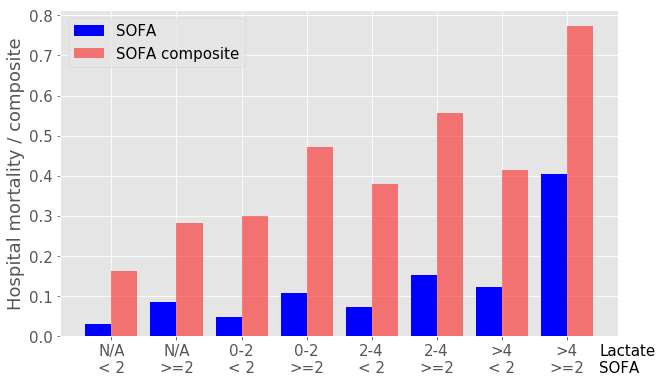

In [22]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=0.4)
plt.bar(xi+0.5,x_sofa_composite,facecolor='r',alpha=0.5,label='SOFA composite',width=0.4)
plt.xticks(np.linspace(0,7,8)+0.3, [x.replace('SOFA','').replace('No lactate','N/A') for x in lbl_sofa])
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality / composite")
plt.text(7.8,-0.09,'Lactate\nSOFA')
plt.show()

In [23]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

print('{:10s}\tSOFA< 2\tSOFA>=2'.format(''),end='')
print('\t\tSOFA< 2\tSOFA>=2'.format(''))
for i in range(len(lbl_sofa)/2):
    i1 = 2*i
    i2 = 2*i+1
    
    print('{:10s}\t{:2.1f}\t{:2.1f}'.format( lbl_sofa[i1].split('\n')[0], 100.0*x_sofa[i1], 100.0*x_sofa[i2] ), end='')
    print('\t\t{:2.1f}\t{:2.1f}'.format( 100.0*x_sofa_composite[i1], 100.0*x_sofa_composite[i2] ))

          	SOFA< 2	SOFA>=2		SOFA< 2	SOFA>=2
No lactate	3.1	8.6		16.3	28.2
0-2       	4.9	10.9		30.0	47.3
2-4       	7.2	15.4		37.9	55.7
>4        	12.2	40.6		41.5	77.4
